In [ ]:
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [81]:

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def SIR(x, param_inf, param_rec):
    """Function based on the following definition of SIR model:
    an healthy individual can be infected w.p. 1-(1-param_inf)^N where N are the infected neighbours around
    an infected individual can recover (and become again suscpetiple) w.p. param_rec

    """
    x = x.unsqueeze(0) # Add a dimension to the starting grid
    # Define the 3x3 kernel with all values set to 1
    kernel = torch.ones(1, 1, 3, 3, dtype=torch.float32)

    # and middle value to 0
    kernel[0][0][1][1] = 0

    # Perform convolution
    neighbors_count = F.conv2d(x.float(), kernel, padding=1)

    #GUMBEL - SOFTMAX TRICK THAT BEHAVES LIKE ~Bern(1-(1-beta)^N)
    #here I always keep the dimensionality of n x n
    bernoulli_param = 1-(1-param_inf)**neighbors_count

    ## add the feature that infected indivduals can recover w.p. param_rec
    bernoulli_param[x==1] = param_rec

    #draw n x n Bernoulli distributed RV according to parameters described above
    random_uniform = torch.rand(x.size())
    y_pred = (bernoulli_param>=random_uniform).int()

    # making sure that if a pixel was already infected, stays infected

    #making sure that an healthy pixel with no neighbours doesnt get infected
    y_pred[neighbors_count==0] = 0

    return y_pred.type(torch.FloatTensor)

In [ ]:
#create synthetic data
n = 100
grid_size = (n,n)
grid = torch.zeros(grid_size, dtype=torch.int8)
grid[int(n/2),int(n/2)] = 1

tau = 50 #number of time step per simulation
nSim = 100 #number of simulations
res = torch.empty(tau*nSim,n,n)

#TRUE VALUES
betaInf = 0.3333 #probability of infection
betaRec = 0.05   #probability of recovery

for i in range(tau*nSim):
    if i%tau==0:
        res[i] = grid
        continue
    next = SIR(res[i-1], betaInf, betaRec)
    res[i] = next

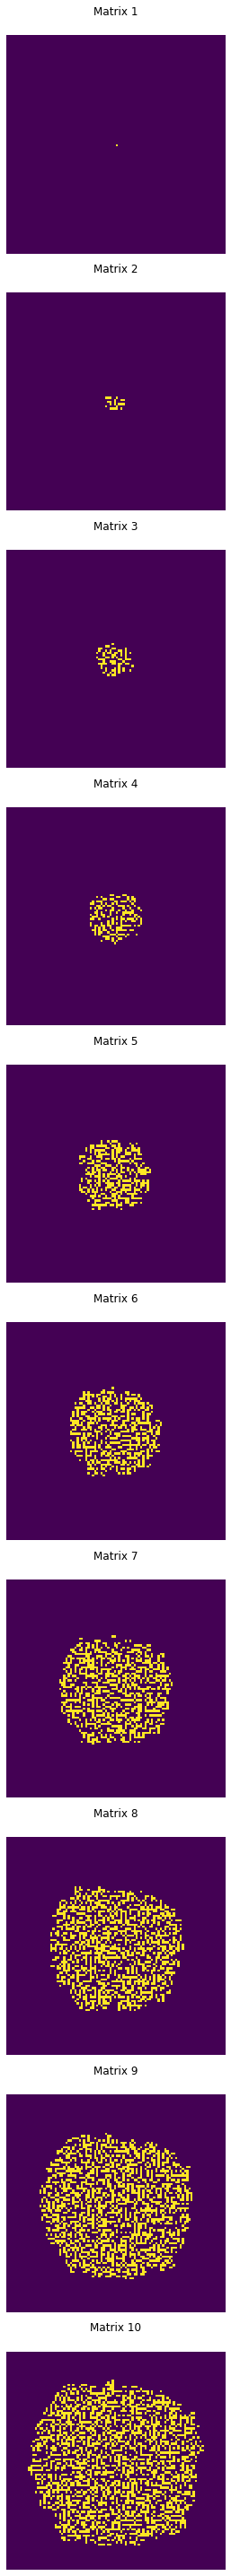

In [150]:
to_be_plotted = res[:50][::5]
fig, axs = plt.subplots(10, 1, figsize=(5, 40))

# Loop through each matrix and plot it using matshow
for i in range(10):
    axs[i].matshow(to_be_plotted[i].numpy(), cmap='viridis')
    axs[i].set_title(f'Matrix {i+1}')
    axs[i].axis('off')  # Hide axes for better visualization

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



In [135]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, sample_gumbel, temperature, paramInf, paramRec):
        """Gumbel-softmax trick that given a list of values of N (neigbours),
        outputs whether every item in the list is accepted or not
        """
        """Gumbel-softmax trick that given a list of values of N (neigbours),
        outputs whether every item in the list is accepted or not
        """
        x = x.unsqueeze(0) # Add a dimension to the starting grid

        # Define the 3x3 kernel with all values set to 1
        kernel = torch.ones(1, 1, 3, 3, dtype=torch.float32)
        # and middle value to 0
        kernel[0][0][1][1] = 0

        # Perform convolution
        neighbors_count = F.conv2d(x, kernel, padding=1)

        #GUMBEL - SOFTMAX TRICK THAT BEHAVES LIKE ~Bern(1-(1-beta)^N)
        #here I always keep the dimensionality of n x n
        logits_input = 1-(1-paramInf)**neighbors_count
        logits_input[x==1] = paramRec
        logits = torch.stack((torch.log(1-logits_input), torch.log(logits_input))).reshape((2,x.size()[1],x.size()[2]))
        softmax_input = logits + sample_gumbel
        #z = F.softmax(softmax_input / temperature, dim=0)
        z = softmax_input

        ctx.save_for_backward(x, sample_gumbel, torch.tensor([temperature]), paramInf, paramRec, z)

        y_pred = z.argmax(dim=0)


        #making sure that an healthy pixel with no neighbours doesnt get infected
        y_pred[neighbors_count[0]==0] = 0

        return y_pred.type(torch.FloatTensor)

    @staticmethod
    def backward(ctx, grad_output):
        """"Straight through estimator
        """
        x, sample_gumbel, temperature, paramInf, paramRec, z = ctx.saved_tensors

        grad_a = F.hardtanh(grad_output) * (1 - x)  # Custom gradient for paramInf that "pays attention" to susceptible indvidual
        grad_b = F.hardtanh(grad_output) * x  # Custom gradient for paramRec that "pays attention" to infected indvidual
        return None, None, None, grad_a, grad_b
        #return None, None, None, torch.tan(grad_output)  # <- return the identity function

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.a = nn.Parameter(torch.tensor([0.99]), requires_grad=True)  #initializing param 'a'
        self.b = nn.Parameter(torch.tensor([0.99]), requires_grad=True)  #initializing param 'a'

    def forward(self, x, sample_gumbel, temperature):
        x = STEFunction.apply(x, sample_gumbel, temperature, self.a, self.b)
        return x

In [136]:
model = MyModel()
optimizer = optim.SGD(model.parameters(), lr=0.0005)
epochs = 15
predicted_parameter_inf = []
predicted_parameter_rec = []

for epoch in range(epochs):
    for i in range(res.size()[0]-1):
        #skip when you reach the final time step of the simulation
        #if i %tau == 29:
        if i %tau == 49:
            continue

        gumbel_sample = sample_gumbel((2,n, n))
        input_data = res[i].type(torch.FloatTensor)
        y_pred= model(x = input_data, sample_gumbel = gumbel_sample, temperature = 0.1)

        loss =  torch.mean((y_pred - res[i+1])**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted_parameter_inf.append(model.a.item())
        predicted_parameter_rec.append(model.b.item())

    print(model.a.item(), model.b.item(), epoch)

0.8467913866043091 0.7007033228874207 0
0.7158929109573364 0.5005849599838257 1
0.6024631857872009 0.3620017468929291 2
0.5113509297370911 0.2659960091114044 3
0.4443640410900116 0.19940564036369324 4
0.3993186354637146 0.15338589251041412 5
0.37117505073547363 0.12162908166646957 6
0.35455578565597534 0.09967461228370667 7
0.34497565031051636 0.08447229862213135 8
0.3396698832511902 0.07386605441570282 9
0.3368767499923706 0.06657586991786957 10
0.33518803119659424 0.061500485986471176 11
0.33427056670188904 0.05792875960469246 12
0.33377495408058167 0.05556291341781616 13
0.33331283926963806 0.05388945713639259 14


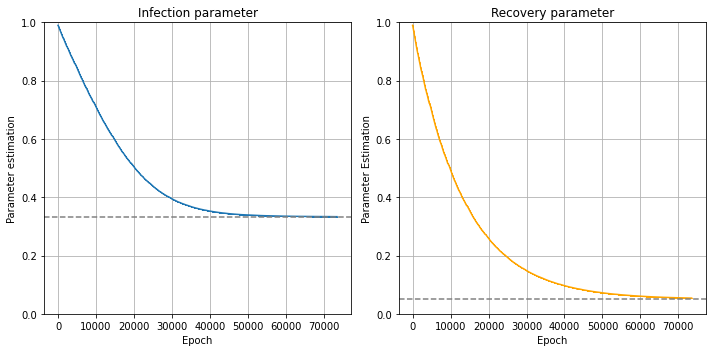

In [137]:
x_values = range(len(predicted_parameter_inf))

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first list
axs[0].plot(x_values, predicted_parameter_inf, marker='o', markersize = 0.01)
axs[0].set_title('Infection parameter')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Parameter estimation')
axs[0].set_ylim(0, 1)
axs[0].axhline(y=0.333, color='grey', linestyle='--')
axs[0].grid(True)


# Plot the second list
axs[1].plot(x_values, predicted_parameter_rec, marker='o', color='orange', markersize = 0.01)
axs[1].set_title('Recovery parameter')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Parameter Estimation')
axs[1].set_ylim(0,1)
axs[1].axhline(y=0.05, color='grey', linestyle='--')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.grid(True)
plt.ylim(0)


# Show the plots
plt.show()